In [2]:
import os
import datetime as dt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
def transform_johns_hopkins(df):
    df = df.groupby('Country/Region').sum()
    cols = list(df.columns)
    cols.remove('Lat')
    cols.remove('Long')
    df = df[cols]
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df.index.name = "Date"
    return df#[columns]

def get_johns_hopkins(kind='confirmed'):
    assert kind in ['confirmed', 'deaths', 'recovered']
    url = f"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{kind}_global.csv"
    df = pd.read_csv(url)
    df = transform_johns_hopkins(df)
    fname = f"data/CSSEGUSandData/time_series_covid19_{kind}_global.csv"
    df.to_csv(fname)
    return df

In [4]:
def transform_sinave_eduardofv(df):
    df = df.groupby('Estado').sum()
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
    df.index.name = "Date"
    return df#[columns]

def get_sinave_eduardofv(kind="confirmados"):
    assert kind in ['confirmados', 'probables', 'muertos', 'descartados']
    url = f"https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_{kind}.csv"
    df = pd.read_csv(url)
    df = transform_sinave_eduardofv(df)
    return df    

In [5]:
def get_new_per_day(df):
    new_per_day = {}
    for location in df.columns:
        d = df[location]
        dif = [d[i] - d[i-1] for i in range(1,len(d))]
        new_per_day[location] = dif

    df_new_per_day = pd.DataFrame(new_per_day)
    df_new_per_day.index = df.index[1:]
    return df_new_per_day

# Mundo

In [6]:
analysis_countries = ["Mexico", "Australia", "US", "Italy", "Korea, South"]
dfw = get_johns_hopkins('confirmed')
dfw[analysis_countries].tail(10)

Country/Region,Mexico,Australia,US,Italy,"Korea, South"
Date,,,,,
2020-03-28,717,3640,121478,92472,9478
2020-03-29,848,3984,140886,97689,9583
2020-03-30,993,4361,161807,101739,9661
2020-03-31,1094,4559,188172,105792,9786
2020-04-01,1215,4862,213372,110574,9887
2020-04-02,1378,5116,243453,115242,9976
2020-04-03,1510,5330,275586,119827,10062
2020-04-04,1688,5550,308850,124632,10156
2020-04-05,1890,5687,337072,128948,10237


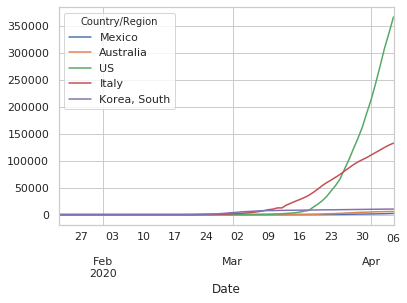

In [7]:
dfw[analysis_countries].plot(logy=False)

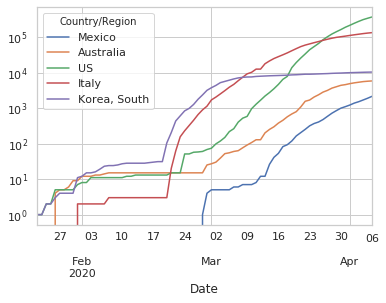

In [8]:
dfw[analysis_countries].plot(logy=True)

In [9]:
dfw_new_per_day = get_new_per_day(dfw)
dfw_new_per_day[analysis_countries].tail()

,Mexico,Australia,US,Italy,"Korea, South"
Date,,,,,
2020-04-02,163,254,30081,4668,89
2020-04-03,132,214,32133,4585,86
2020-04-04,178,220,33264,4805,94
2020-04-05,202,137,28222,4316,81
2020-04-06,253,110,29542,3599,47


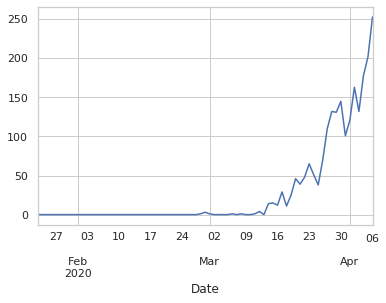

In [10]:
dfw_new_per_day['Mexico'].plot()

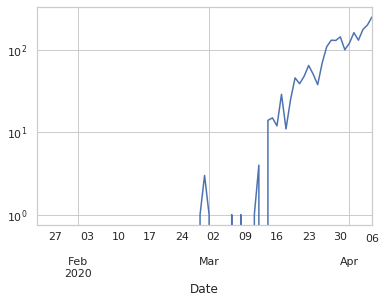

In [11]:
dfw_new_per_day['Mexico'].plot(logy=True)

In [12]:
def calculate_new_per_period(df_new_per_day, PERIOD=7):
    new_per_period = {}
    for country in df_new_per_day.columns:
        d = df_new_per_day[country]
        cum = [sum(d[(i-PERIOD):i]) for i in range(PERIOD, len(d))]
        new_per_period[country] = cum
    return new_per_period

In [13]:
def cum_and_new_from_init(dfw, new_per_period, country, INIT=99):
    d = dfw[country]
    cum_from_init = d[d>INIT]
    new_from_init = new_per_period[country][-len(cum_from_init):]
    assert len(cum_from_init) == len(new_from_init)
    return cum_from_init, new_from_init

In [14]:
dfw.columns[dfw.columns.str.contains("Korea")]

Index(['Korea, South'], dtype='object', name='Country/Region')

Text(0, 0.5, 'new cases last days')

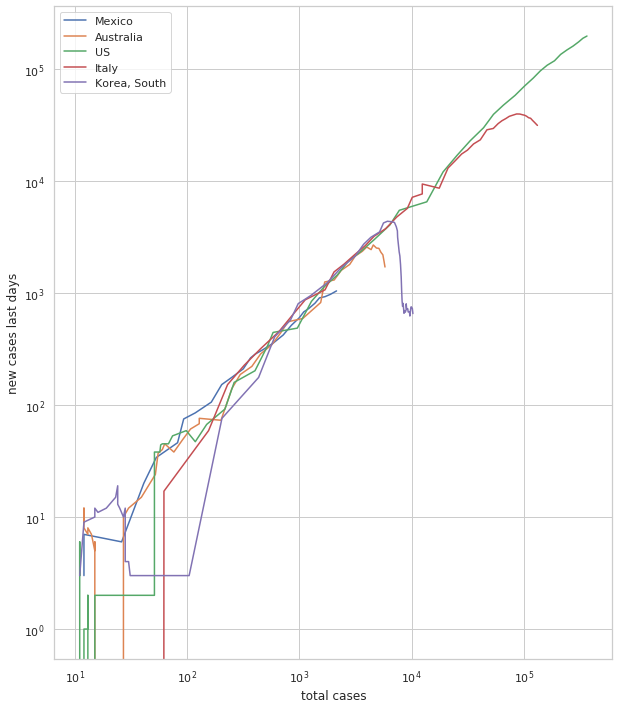

In [15]:
new_per_period = calculate_new_per_period(dfw_new_per_day, PERIOD=7)

#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in analysis_countries:
    cum, new = cum_and_new_from_init(dfw, new_per_period, country, INIT=10)
    plt.plot(cum, new)
plt.legend(analysis_countries)
plt.xlabel("total cases")
plt.ylabel("new cases last days")

# México

In [16]:
estados = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]

dfmx = get_sinave_eduardofv('confirmados')
dfmx_descartados = get_sinave_eduardofv('descartados')
dfmx_probables = get_sinave_eduardofv('probables')
dfmx[estados].tail(10)

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-03-30,205,75,90,27
2020-03-31,234,76,94,29
2020-04-01,296,78,99,29
2020-04-02,327,84,104,32
2020-04-03,384,85,116,35
2020-04-04,469,88,120,36
2020-04-05,560,91,123,38
2020-04-06,609,93,126,40


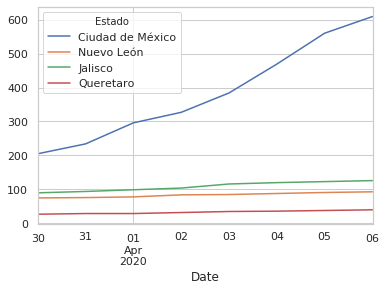

In [17]:
dfmx[estados].plot(logy=False)

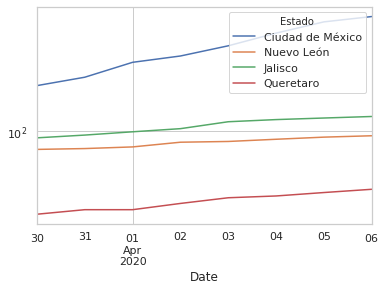

In [18]:
dfmx[estados].plot(logy=True)

In [19]:
total_mx = dfmx.sum(axis=1)
total_mx[-10:]

Date
2020-03-30    1094
2020-03-31    1215
2020-04-01    1378
2020-04-02    1510
2020-04-03    1688
2020-04-04    1890
2020-04-05    2143
2020-04-06    2439
dtype: int64

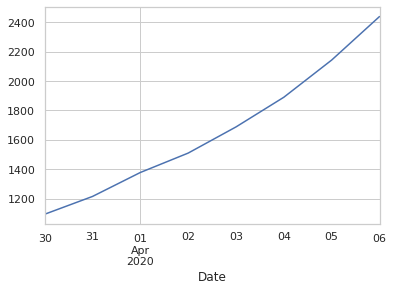

In [20]:
total_mx.plot()

In [21]:
dfmx_new_per_day = get_new_per_day(dfmx)
dfmx_new_per_day[estados].tail()

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-02,31,6,5,3
2020-04-03,57,1,12,3
2020-04-04,85,3,4,1
2020-04-05,91,3,3,2
2020-04-06,49,2,3,2


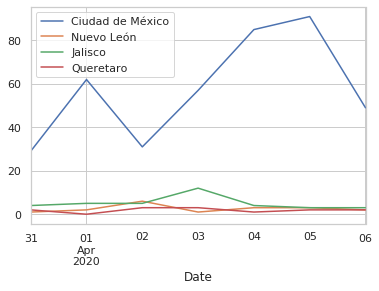

In [22]:
for estado in estados:
    dfmx_new_per_day[estado].plot()
plt.legend(estados)

In [23]:
total_probables = dfmx_probables.sum(axis=1)
total_descartados = dfmx_descartados.sum(axis=1)
total_pruebas = total_mx + total_probables + total_descartados
prop_confirmados = total_mx / total_pruebas
prop_confirmados[-10:]

Date
2020-03-30    0.115389
2020-03-31    0.110374
2020-04-01    0.112233
2020-04-02    0.107973
2020-04-03    0.107612
2020-04-04    0.109986
2020-04-05    0.118831
2020-04-06    0.119121
dtype: float64

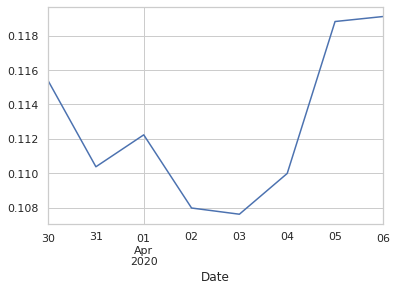

In [24]:
prop_confirmados.plot()